### Summary of findings

- The dataset is imbalanced, with 'No findings' being the most common label.
- Certain diseases tend to co-occur, such as 'Infiltration' and 'Atelectasis'.
- Sample images from the training set show a variety of chest X-ray presentations.
- Images are in RGB format, which may require conversion to grayscale for certain analyses.


In [29]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from glob import glob
from PIL import Image

In [2]:
dataset = load_dataset("Sohaibsoussi/NIH-Chest-X-ray-dataset-small")

In [3]:
# convert each dataset dict to a pandas df for easier access
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

full_df = pd.concat([train_df, val_df, test_df], axis=0)
print(full_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7335 entries, 0 to 1278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   7335 non-null   object
 1   labels  7335 non-null   object
dtypes: object(2)
memory usage: 171.9+ KB
None


#### Dataset Overview

In [4]:
print("--- Dataset Splits ---")
print(f"Training set size: {len(train_df)} samples")
print(f"Validation set size: {len(val_df)} samples")
print(f"Test set size: {len(test_df)} samples")
print(f"Total size: {len(full_df)} samples")

--- Dataset Splits ---
Training set size: 4326 samples
Validation set size: 1730 samples
Test set size: 1279 samples
Total size: 7335 samples


#### Label Distribution Analysis

In [35]:
label_names = dataset['train'].features['labels'].feature.names
label_names

['No Finding',
 'Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax',
 'Consolidation',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Pleural_Thickening',
 'Hernia']

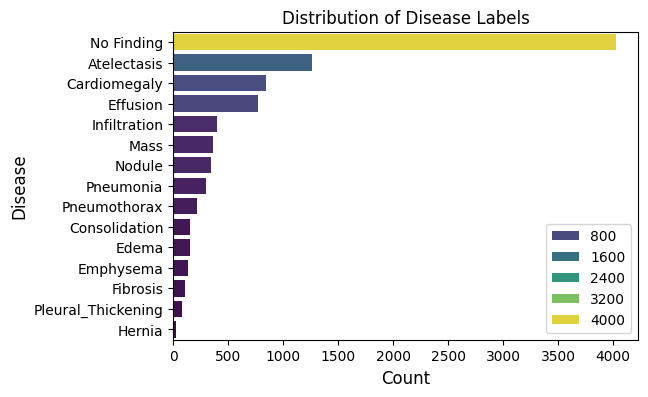


--- Label Counts ---
0     4025
1      768
2      149
3      840
4     1261
5      362
6      403
7       82
8      342
9      301
10     110
11     157
12     131
13     213
14      23
Name: count, dtype: int64


In [60]:
all_labels = [label for sublist in full_df['labels'] for label in sublist]
label_counts = pd.Series(all_labels).value_counts()

# plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(y=label_names, 
            x=label_counts.values,
            hue=label_counts.values,
            palette='viridis')

plt.title('Distribution of Disease Labels', fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Disease', fontsize=12)
plt.show()

print("\n--- Label Counts ---")
print(label_counts.sort_index())

#### Visualizing relationship between labels

For example, if two diseases often co-occur, we can visualize that with a heatmap or pairplot.

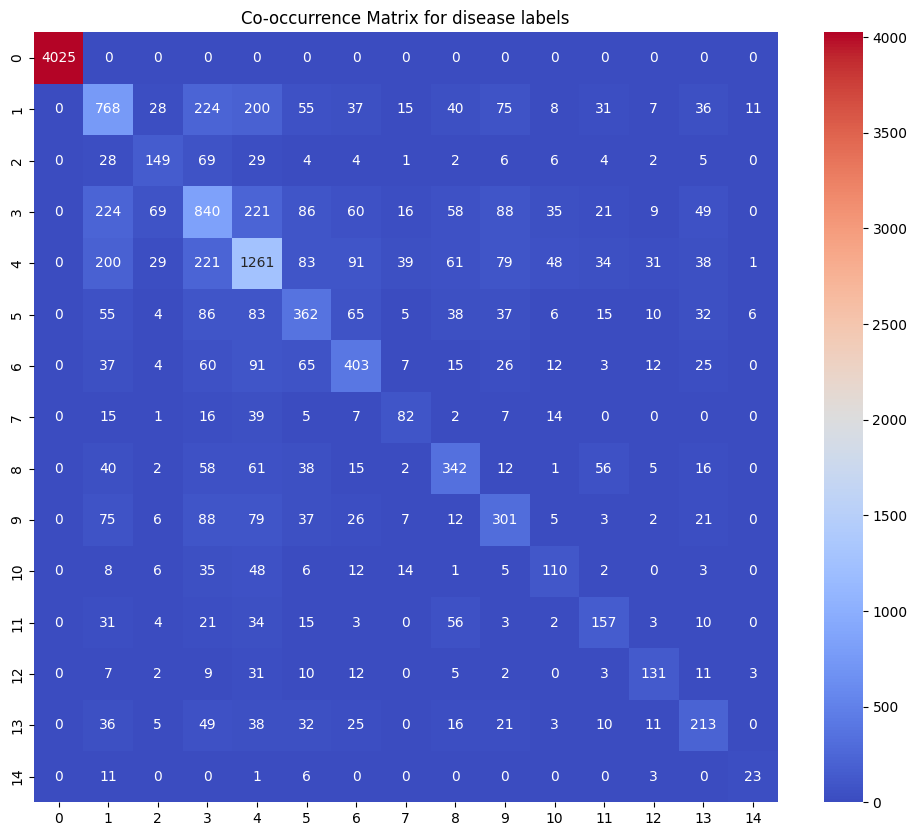

In [54]:
label_counts.sort_index(inplace=True)
unique_labels = label_counts.index.tolist()

# create a binary matrix if the label is present for the image
# adding new columns
for label in unique_labels:
    full_df[label] = full_df['labels'].apply(lambda labels: 1 if label in labels else 0)

# select only the label columns
label_df = full_df[unique_labels]

# perform dot product
co_occurence_matrix = label_df.T.dot(label_df)

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurence_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.title("Co-occurrence Matrix for disease labels")
plt.show()

#### Visualize samples from training set

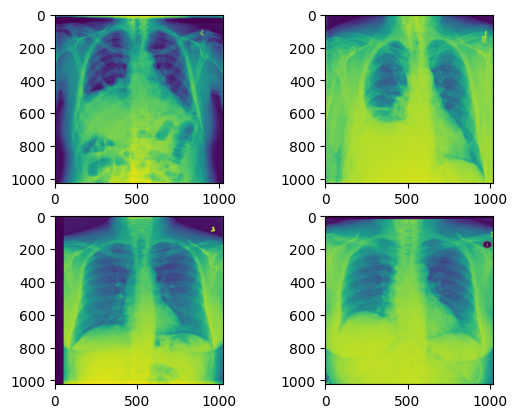

In [26]:
sample = np.random.choice(len(train_df), size=4)

for i in range(len(sample)):
    plt.subplot(2, 2, i+1)
    img = dataset['train'][sample[i]]['image']
    plt.imshow(img)
plt.show()

#### Apply histogram equalization to images

In [30]:
class ApplyHE:
    def __init__(self):
        pass

    def __call__(self, img):
        img_np = np.array(img)
        # RGB = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
        if len(img_np.shape) == 2:
            eq_img = cv2.equalizeHist(img_np)
        else:
            if img_np.shape[2] == 3:
                img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            eq_img = cv2.equalizeHist(img_np)

        eq_img_rgb = cv2.cvtColor(eq_img, cv2.COLOR_GRAY2RGB)
        return Image.fromarray(eq_img_rgb)
    
class ApplyCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        img_np = np.array(img)
        # RGB = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
        if len(img_np.shape) == 2:
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            clahe_img = clahe.apply(img_np)
        else:
            if img_np.shape[2] == 3:
                img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            clahe_img = clahe.apply(img_np)

        clahe_img_rgb = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)
        return Image.fromarray(clahe_img_rgb)
    

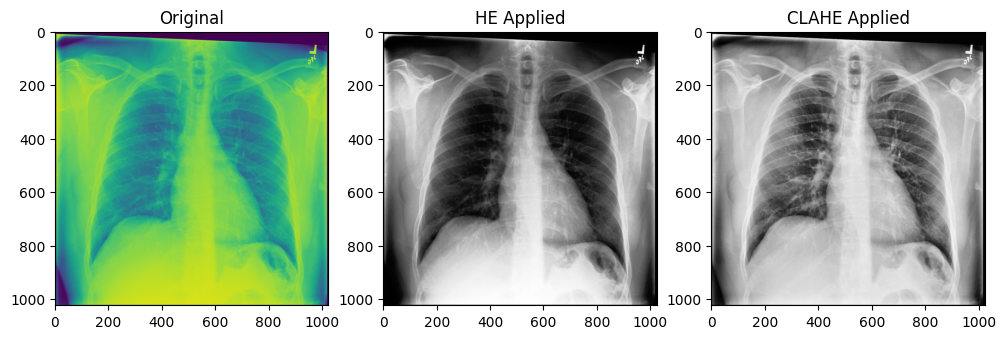

In [32]:
he_tfms = ApplyHE()
clahe_tfms = ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8))

sample = np.random.choice(len(train_df))
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    img = dataset['train'][sample]['image']
    if i == 0:
        plt.title("Original")
        plt.imshow(img)
    elif i == 1:
        plt.title("HE Applied")
        he_img = he_tfms(img)
        plt.imshow(he_img)
    elif i == 2:
        plt.title("CLAHE Applied")
        clahe_img = clahe_tfms(img)
        plt.imshow(clahe_img)